## Python statistics essential training - 05_04_crossvalidation

In the last video we saw a few classical analytics have it techniques to have it with goodness of fit, and to compare models based on their explanatory power and simplicity. Now I want to show you how to implement a much simpler strategy known as Cross Validation, which is used in machine learning to compare models.

![Cross Validation diagram](crossvalidation.png "Cross Validation")

We divide the data into a training set which we use to feed the model, and a testing set which we use to evaluate the models prediction error. So instead of concentrating on in-sample error as we do with classical techniques, we will look at how to sample prediction error. Models then can't look better by over fitting the data they're trained on. Instead they need to, in some sense, understand something about the world.

I have all ready included code to load our data set. I import packages.

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading gapminder data for year 1985 (Live Aid!).

In [6]:
gapminder = pd.read_csv('gapminder.csv')

In [7]:
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [8]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    pp.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Model formulas from the last two videos

In [9]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')

To divide up our data we first shuffle it with a Panda's data frame method sample. The resulting data search should be the same length as the original, and there is no replacement this time.

In [10]:
shuffled = gdata.sample(len(gdata))

Then we can use the Panda's locator `iloc` which goes by row number to divide the rows in two. Enter your division with a double slash and it shows I have a proper index.

In [11]:
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:]

We now fit the model to the training data. Using one of our formulas.

In [12]:
surviving = smf.ols(f_surviving, data=training).fit()

I plot the result.

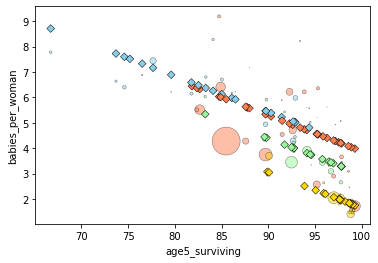

In [14]:
plotfit(surviving, training)

The in-sample mean square error is 1.02.

In [16]:
surviving.mse_resid

1.0118014874770132

We now tryout the model on the testing data. Plotfit contains a call to stats model predict we generate a moderate response for this particular data set.

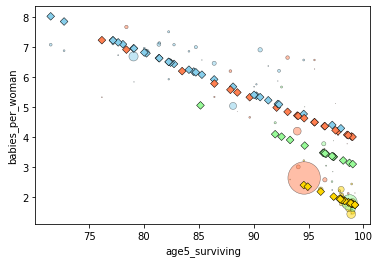

In [17]:
plotfit(surviving, testing)

We see the data points are different, but the fit is comparable.

To obtain the mean square there we need to do a little work. We first:

- Compute the residuals by apply model prediction to the testing data set
- We subtract the observe data
- Then we compute the number of degrees of freedom, which is the length of the data, minus the number of parameters in the model, minus one since the number of parameters doesn't count the constant, but we should
- Finally, we square up the residuals, sum them, and divide by the number of degrees of freedom.

In [18]:
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model - 1
np.sum(resid**2 / df)

0.9572173793191341

The mean square error on the testing data is a little higher since now there's no overfitting.

So let's automate this procedure and use it on the three models. Since the results depend on the shuffling and are rather noisy, we'll repeat a few times and take the average.

So I'll make a function that is generic in terms of the formula, of the response variable that we're looking at, and of the number of repetitions.

In [19]:
def cross_validate(data, formula, response, n=100):
    ret = []
    
    #  We repeat n times
    for i in range(n):
        # Shuffle
        shuffled = data.sample(len(data))
        
        # Split the data into training and testing sets
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        # Train the model
        trained = smf.ols(formula, data=training).fit()
        
        # Compute the mean square error
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2 / df)
        
        # Collect all mse in a Python list
        ret.append(mse)
    
    # Return mse average
    return np.mean(ret)

Let's try this out.

In [21]:
cross_validate(gdata, f_groupmeans, 'babies_per_woman')

1.6067353640938902

In [22]:
cross_validate(gdata, f_surviving, 'babies_per_woman')

1.0428051846271433

In [23]:
cross_validate(gdata, f_srp, 'babies_per_woman')

1.231802082205379

Cross validation confirms the verdict of analytical goodness of fit measures. The model of intermediate complexity seems to hit the sweet spot in terms of explanatory power. In the real world, all data analysts use k-fold cross-validation instead of dividing the data in two we divide it in k subsets, and then in k successive trials we hold out one of the subsets for testing and trains on all the rest. Finally, the k resulting models are averaged. k-fold cross validation is supported in the Python package scikit-learn.